# 0.0 Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn as sns
import plotly.figure_factory as ff

from scipy.stats import yeojohnson, shapiro
from tabulate import tabulate
from matplotlib import pyplot as plt
from pycorrcat import pycorrcat

## 0.1 Load data

In [2]:
feature_engineering = catalog.load("feature_engineering")

[09/23/23 17:29:08] INFO     Loading data from 'feature_engineering' (CSVDataSet)...            ]8;id=276490;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=517769;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

## 0.2 Helper Functions

In [3]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    sns.set()
    
    warnings.filterwarnings('ignore')
    return None


notebook_settings()

# 4.0 Exploratory Data Analysis

In [4]:
exploratory_data_analysis = feature_engineering.copy()

exploratory_data_analysis.head()

,show_id,title,director,cast,country,date_added,release_year,rating,listed_in,description,minutes,duration_bins,years_since_release,description_length,movie_stage,number_of_directors,number_of_casts,number_of_countrys,number_of_listed_ins,films_by_director,films_by_cast_member,films_per_country,films_per_genre
0,81145628,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,41,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,90,long,0,140,Development,2,10,4,2,1.000,2.200,564.250,96.500
1,80117401,Jandino: Whatever it Takes,others_directors,Jandino Asporaat,United Kingdom,2016-09-09,2016,52,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,94,long,0,145,Development,1,1,1,1,129.000,2.000,170.000,273.000
2,80125979,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,57,Comedies,When nerdy high schooler Dani finally attracts...,99,long,0,148,Development,1,12,1,1,1.000,1.750,1482.000,73.000
3,70304989,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada",2017-09-08,2014,61,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",110,long,3,149,Released,1,9,4,3,1.000,3.333,412.750,14.333
4,80164077,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,2017-09-08,2017,49,Stand-Up Comedy,Fabrizio Copano takes audience participation t...,60,medium,0,149,Development,2,1,1,1,1.000,3.000,9.000,273.000


## 4.1 Univariate Analysis

It is not necessary to execute the code, you can check the result in `/docs/SWEETVIZ_REPORT.html`.

In [5]:
# # We will use sweetviz for univariate automated analysis
# my_report = sv.analyze(exploratory_data_analysis)
# my_report.show_html(filepath='../docs/SWEETVIZ_REPORT.html', layout='widescreen')

### 4.1.1 Sweetviz's main analyses

Sweetviz is a powerful tool for automating analysis. The result is made up of several graphs which can be overwhelming to consult. For now, I'm highlighting the main information extracted, but it would be interesting to enrich this session with graphs in a second version:


### 4.1.2 Response Variable

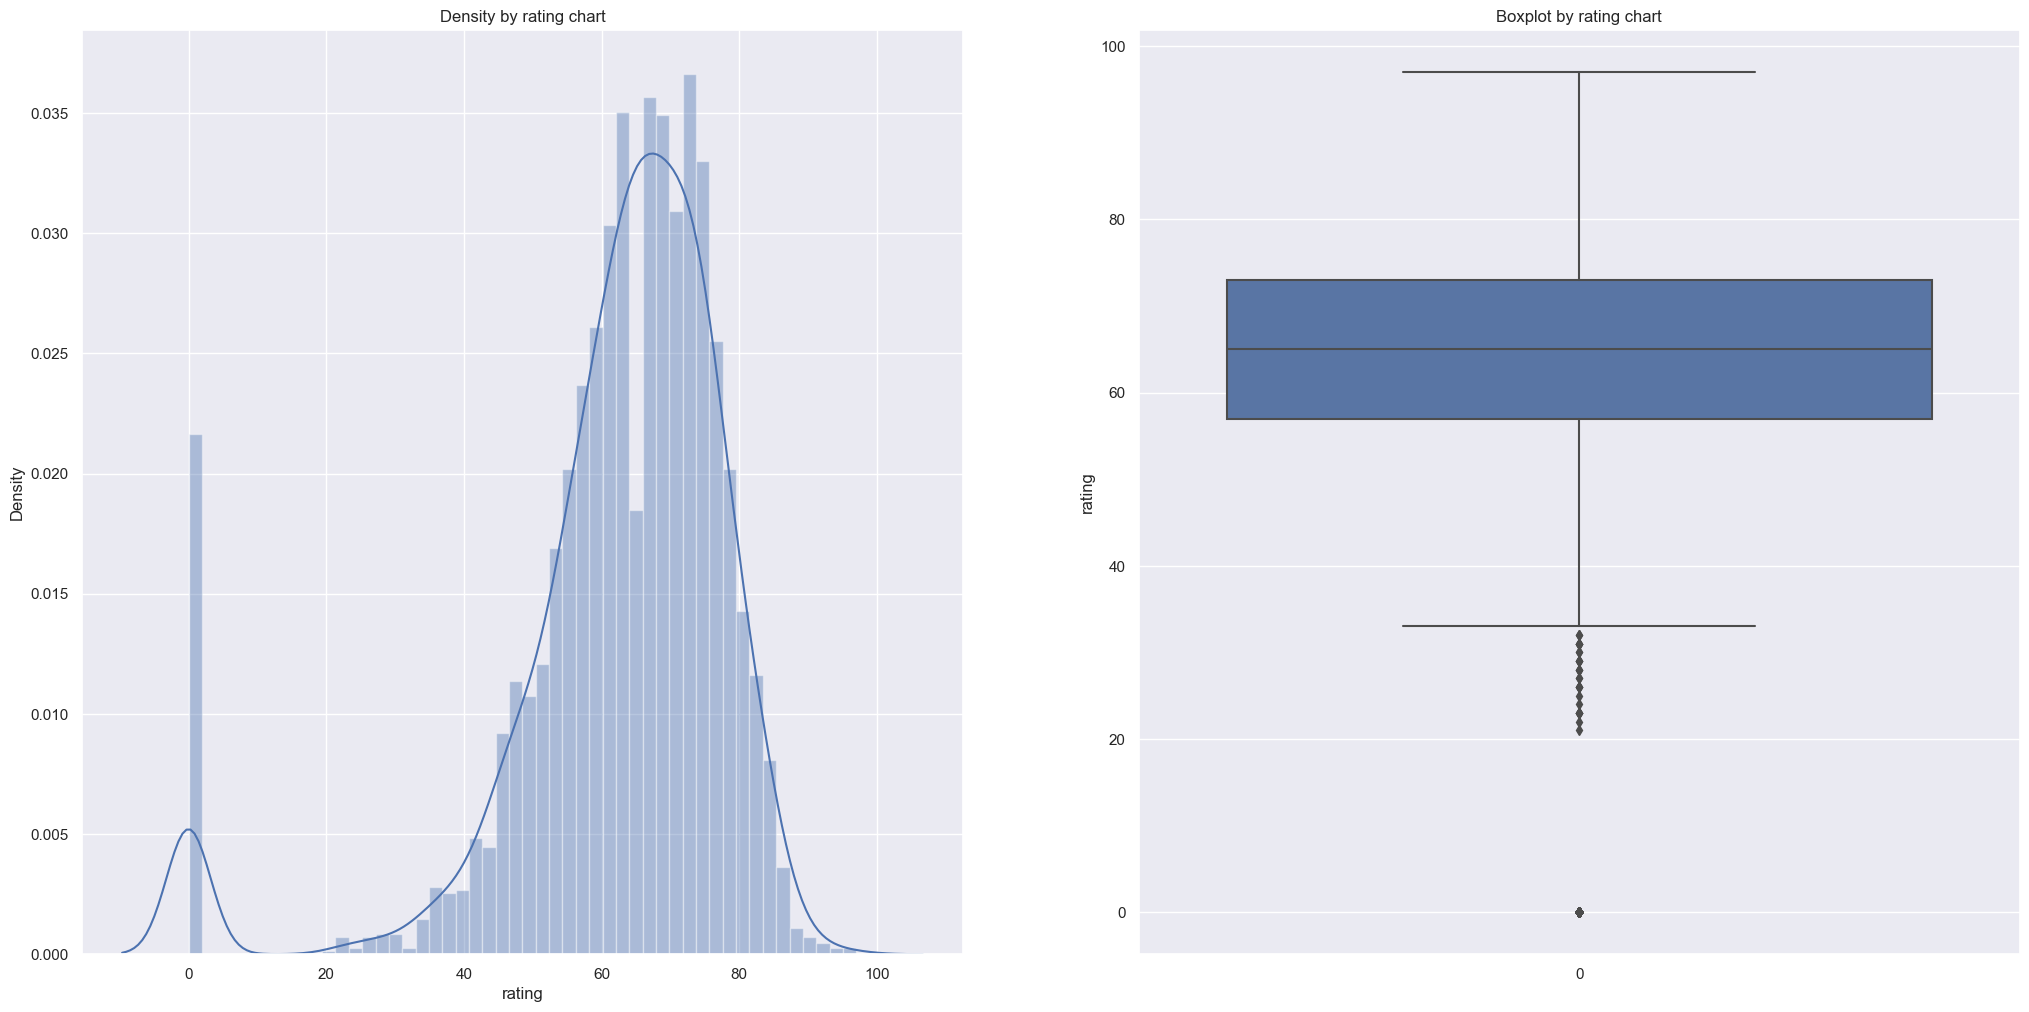

In [6]:
plt.subplot(1, 2, 1)
plt.title('Density by rating chart')
sns.distplot(exploratory_data_analysis['rating'], kde=True)

plt.subplot(1, 2, 2)
plt.title('Boxplot by rating chart')
sns.boxplot(exploratory_data_analysis['rating'])
plt.ylabel('rating');

- The response variable has patterns similar to the normal distribution, but we can improve this scenario in order to develop a generalist model.

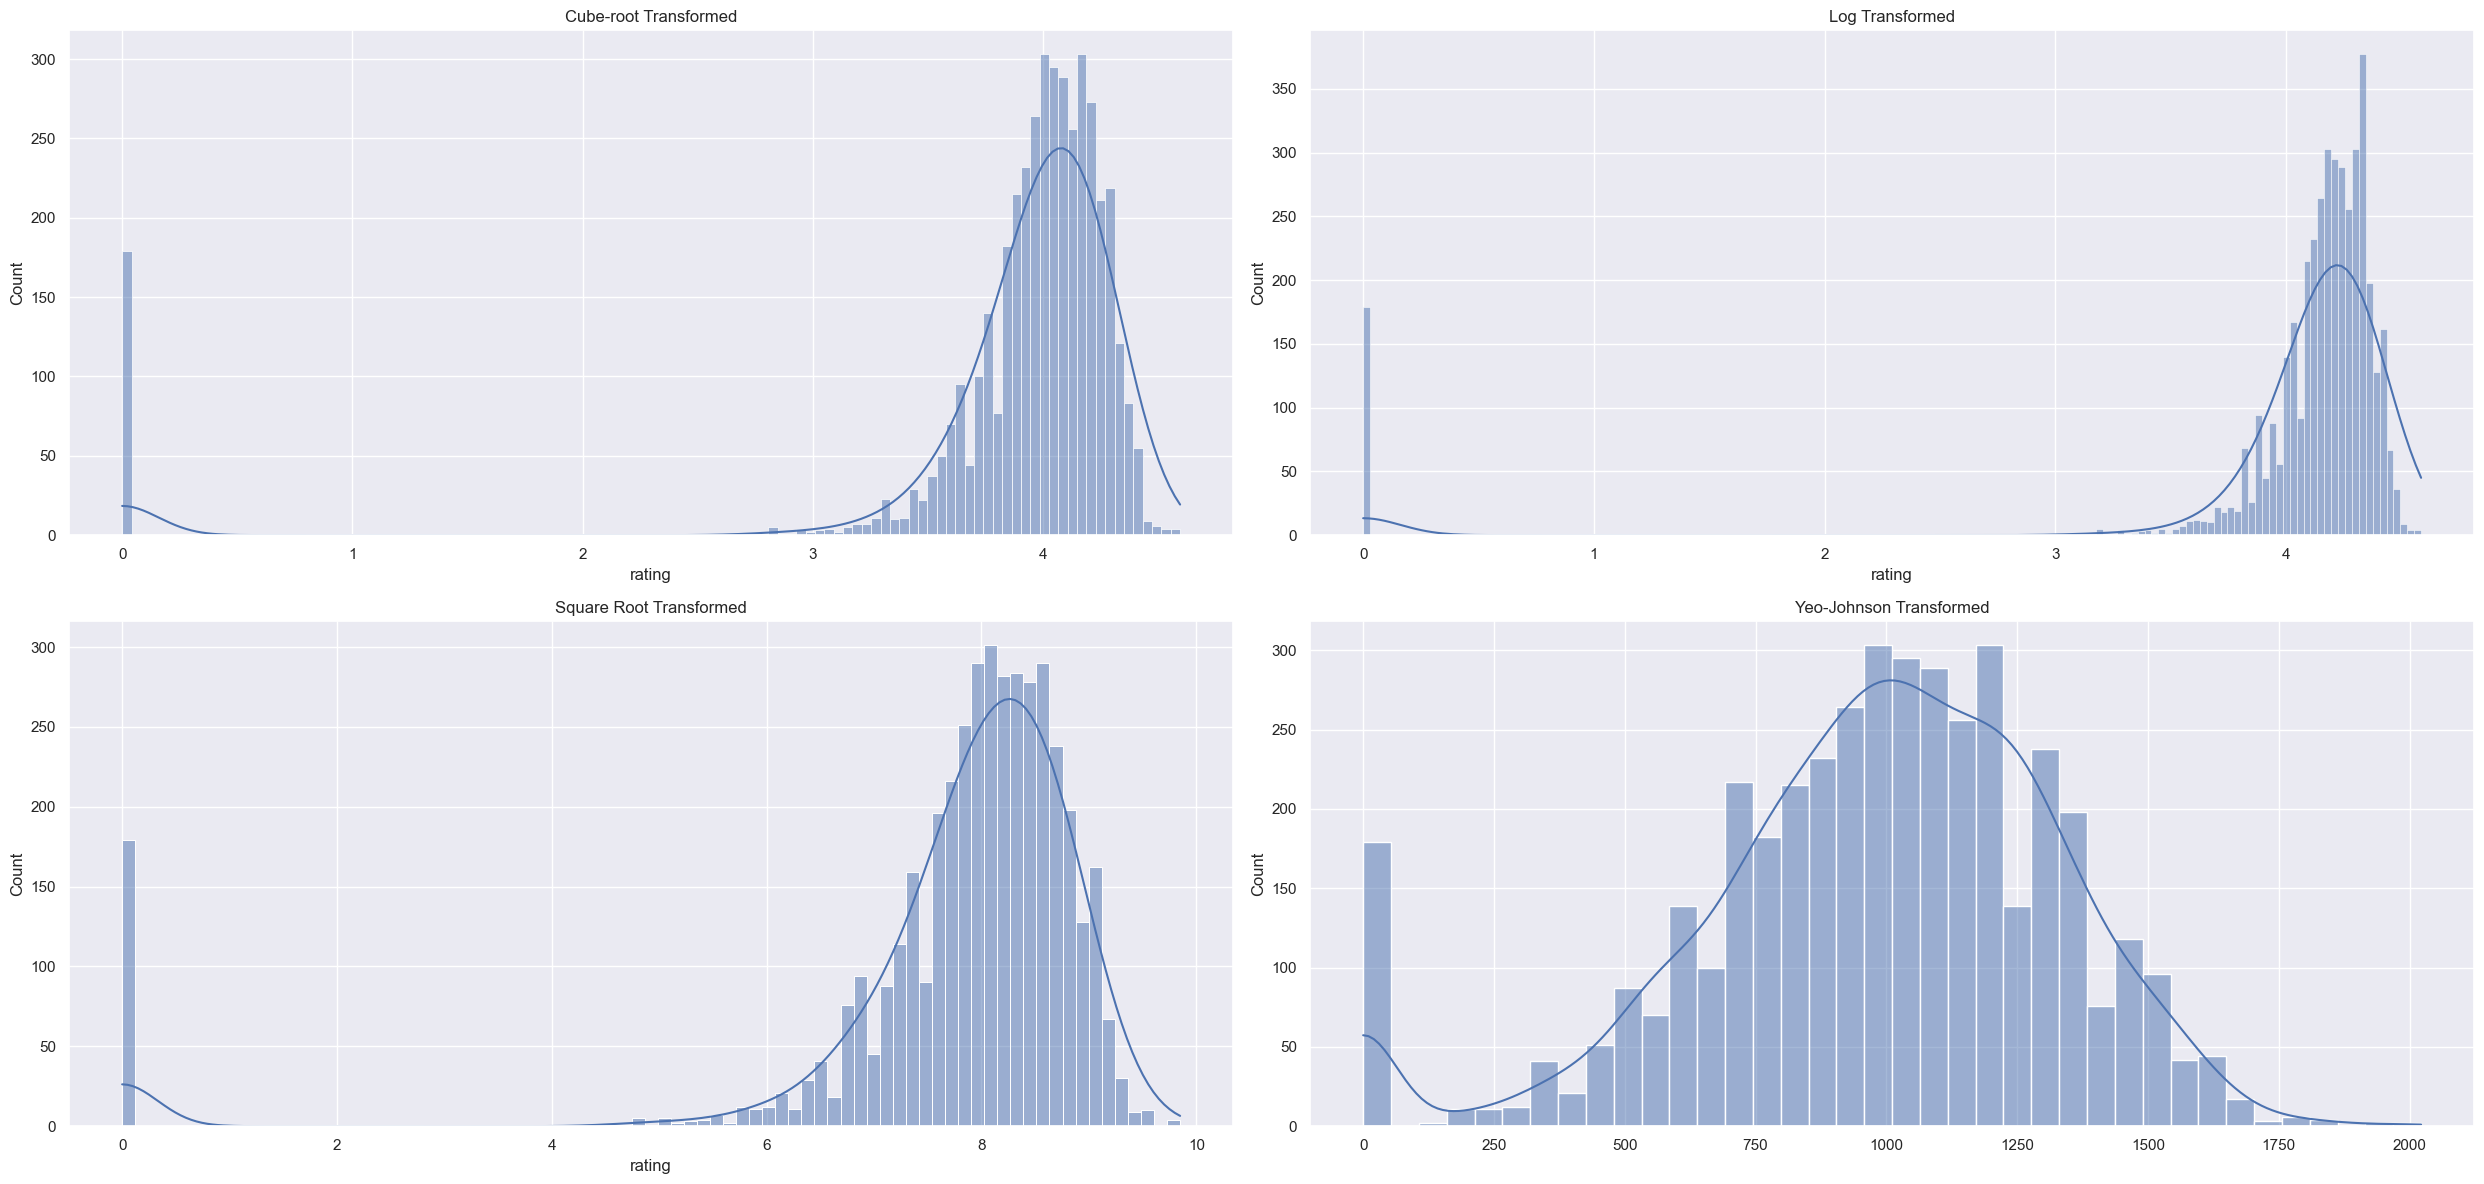

In [7]:
# Original distribution and transformations of the 'rating' variable
log_transformed = np.log1p(exploratory_data_analysis['rating'])  # Logarithmic
sqrt_transformed = np.sqrt(exploratory_data_analysis['rating'])  # Square root
yeojohnson_transformed, _ = yeojohnson(exploratory_data_analysis['rating'])  # Yeo-Johnson
cube_root_transformed = np.cbrt(exploratory_data_analysis['rating']) # Apply cube root transformation

fig, ax = plt.subplots(2, 2)

sns.histplot(cube_root_transformed, kde=True, ax=ax[0, 0])
ax[0, 0].set_title('Cube-root Transformed')
sns.histplot(log_transformed, kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Log Transformed')
sns.histplot(sqrt_transformed, kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Square Root Transformed')
sns.histplot(yeojohnson_transformed, kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Yeo-Johnson Transformed')

plt.tight_layout()
plt.show()

In [8]:
# Shapiro-Wilk test for normality
test_results = {}
transformations = [log_transformed, sqrt_transformed, yeojohnson_transformed, cube_root_transformed]

for i, trans in enumerate(['Log', 'Square Root', 'Yeo-Johnson', 'Cube-root']):
    _, p_value = shapiro(transformations[i])
    test_results[trans] = p_value

test_results

{'Log': 0.0, 'Square Root': 0.0, 'Yeo-Johnson': 8.847540433088324e-33, 'Cube-root': 0.0}

For the results, a p-value below 0.05 suggests that the distribution is not normal.
 
In all cases, the p-value is extremely small, suggesting that none of the distributions is perfectly normal. 

Although the theory calls for a normal distribution, in practice we should try to violate the assumptions as little as possible, given the situation and, based on the graphs, the Yeo-Johnson transformation was the closest to a normal distribution, even though the Shapiro-Wilk test suggests that it is not perfectly normal.

In summary, we will apply this transformation when preparing the data.

## 4.2 Bivariate Analysis

### **Hypothesis 1**: Action films have an average rating 10% higher than comedy films.

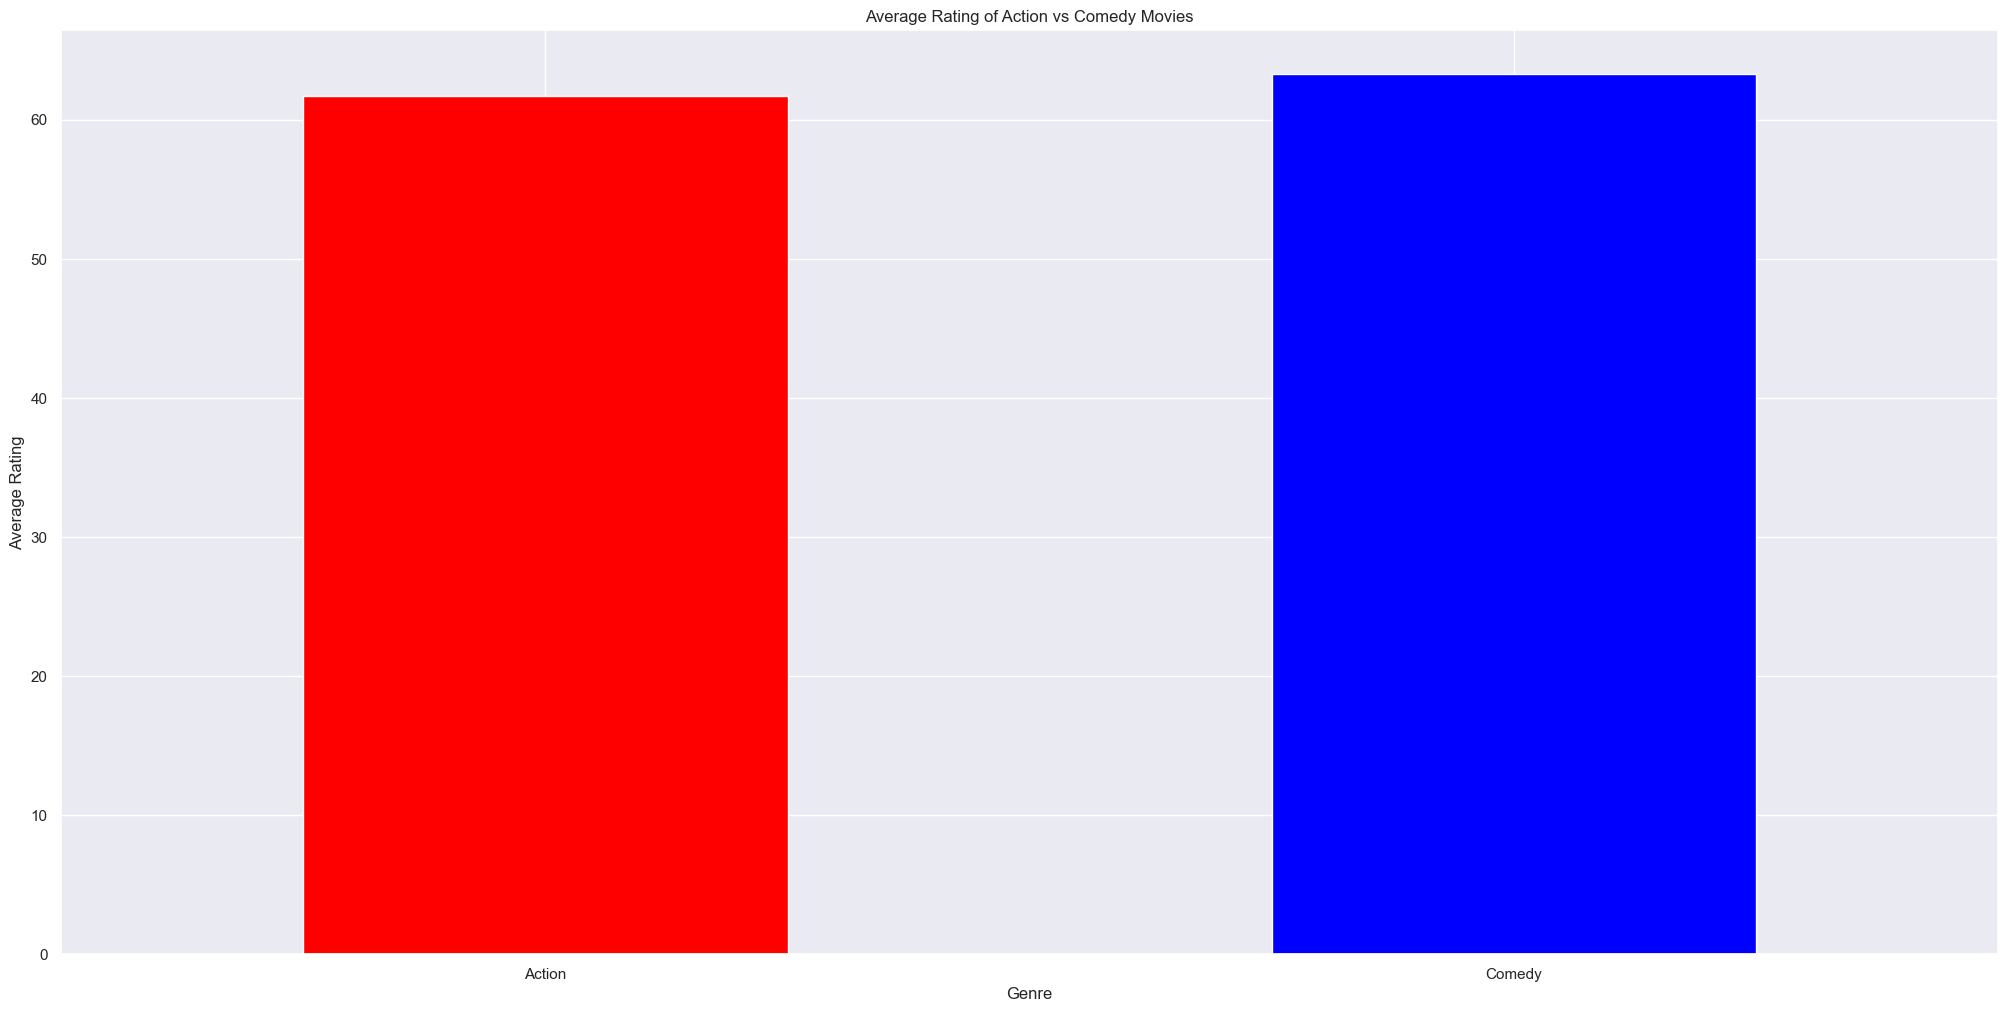

In [9]:
# Filtering the data for movies of genre Action and Comedy and then getting their average ratings
genres = ['Action', 'Comedy']
genre_ratings = (exploratory_data_analysis[exploratory_data_analysis['listed_in'].str.contains('|'.join(genres))]
                 .groupby(exploratory_data_analysis['listed_in'].str
                          .extract('({})'.format('|'.join(genres)))[0])['rating'].mean())

genre_ratings.plot(kind='bar', color=['red', 'blue'])
plt.title('Average Rating of Action vs Comedy Movies')
plt.ylabel('Average Rating')
plt.xlabel('Genre')
plt.xticks(rotation=0)
plt.show()

In [10]:
difference = ((genre_ratings['Action'] - genre_ratings['Comedy']) / genre_ratings['Comedy']) * 100

print(f"The average rating for {genre_ratings.index[0]} films is approximately {genre_ratings['Action']:.2f} %.")
print(f"The average rating for {genre_ratings.index[1]} films is approximately {genre_ratings['Comedy']:.2f} %.")

print(f"The difference between the categories is {difference:.2f}% which means that", end=" ")

hipo_perc = 10
if difference >= hipo_perc:
    print(f"hypothesis was VALIDATED: {genre_ratings.index[0]} movies have an average rating at least {hipo_perc}% higher than {genre_ratings.index[1]} movies.")
else:
    print(f"hypothesis was REJECTED: {genre_ratings.index[0]} movies do not have an average rating {hipo_perc}% higher than {genre_ratings.index[1]} movies.")

The average rating for Action films is approximately 61.72 %.
The average rating for Comedy films is approximately 63.28 %.
The difference between the categories is -2.46% which means that hypothesis was REJECTED: Action movies do not have an average rating 10% higher than Comedy movies.


- Insights can be born out of different behaviors, which break assumptions and generate actionable insights; analysis shows similar behavior, which does not contribute to possible insights.

### **Hypothesis 2**: Films directed by directors who have released more than 5 films have an average rating 15% higher than those directed by directors with less than 5 films.

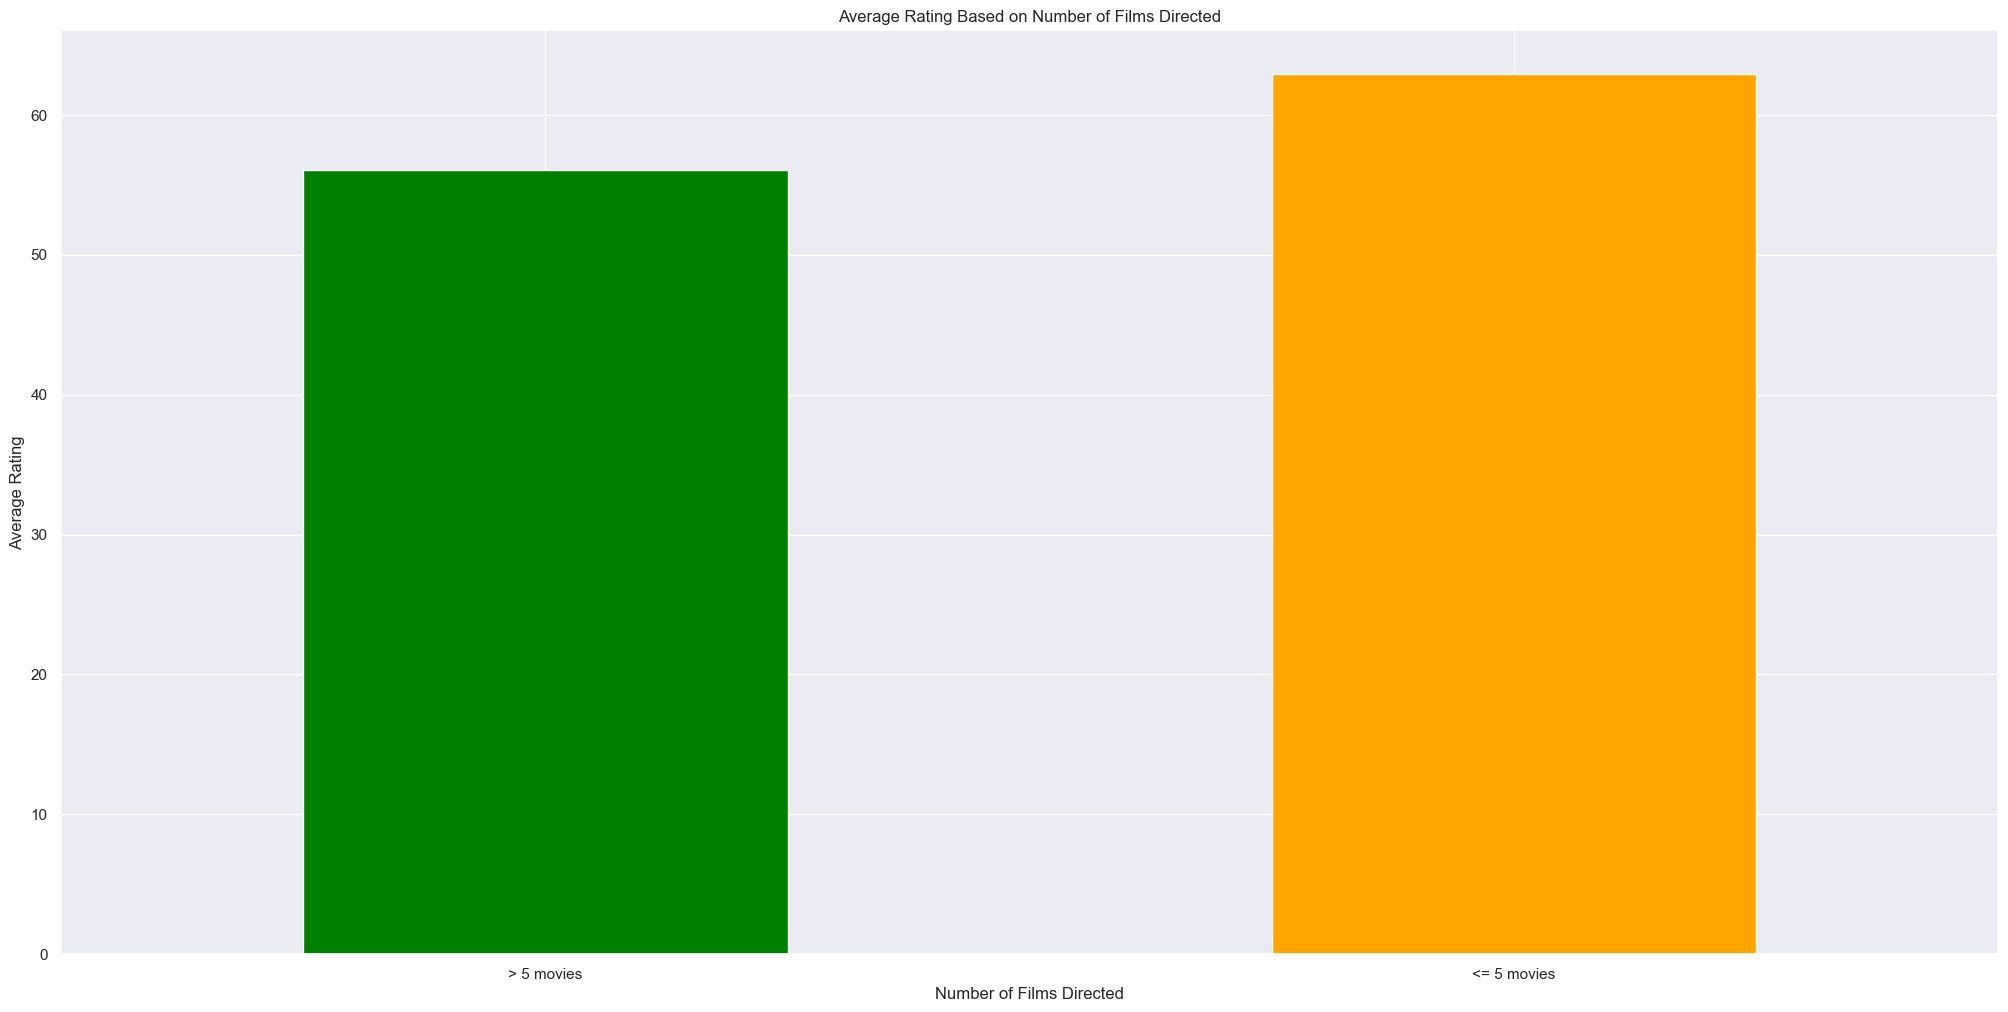

In [11]:
# Grouping by director and counting the number of movies they directed
director_counts = exploratory_data_analysis.groupby('director').size()

# Filtering directors who directed more than 5 movies and less than 5 movies
directors_more_than_5 = director_counts[director_counts > 5].index
directors_less_or_equal_5 = director_counts[director_counts <= 5].index

# Calculating average ratings for both groups
rating_more_than_5 = exploratory_data_analysis[exploratory_data_analysis['director'].isin(directors_more_than_5)]['rating'].mean()
rating_less_than_5 = exploratory_data_analysis[exploratory_data_analysis['director'].isin(directors_less_or_equal_5)]['rating'].mean()

director_ratings = pd.Series([rating_more_than_5, rating_less_than_5], index=['> 5 movies', '<= 5 movies'])

director_ratings.plot(kind='bar', color=['green', 'orange'])
plt.title('Average Rating Based on Number of Films Directed')
plt.ylabel('Average Rating')
plt.xlabel('Number of Films Directed')
plt.xticks(rotation=0)
plt.show()

In [12]:
difference = ((director_ratings['> 5 movies'] - director_ratings['<= 5 movies']) / director_ratings['<= 5 movies']) * 100

print(f"The average rating for director with {director_ratings.index[0]} is approximately {director_ratings['> 5 movies']:.2f} %.")
print(f"The average rating for director with {director_ratings.index[1]} is approximately {director_ratings['<= 5 movies']:.2f} %.")

print(f"The difference between the categories is {difference:.2f}% which means that", end=" ")

hipo_perc = 15
if difference >= hipo_perc:
    print(f"hypothesis was VALIDATED: director with {director_ratings.index[0]} have an average rating at least {hipo_perc}% higher than {director_ratings.index[1]}.")
else:
    print(f"hypothesis was REJECTED: director with {director_ratings.index[0]} do not have an average rating {hipo_perc}% higher than {director_ratings.index[1]}.")

The average rating for director with > 5 movies is approximately 56.04 %.
The average rating for director with <= 5 movies is approximately 62.90 %.
The difference between the categories is -10.91% which means that hypothesis was REJECTED: director with > 5 movies do not have an average rating 15% higher than <= 5 movies.


- The aim was to understand whether apparently more experienced directors had a positive relationship with the scores, in fact generating an opposite situation can break a premise, perhaps novice directors have some kind of support or freedom in their work that contributes

### **Hypothesis 3**: Films with casts that have appeared in more than 10 listed films have an average rating 10% higher.

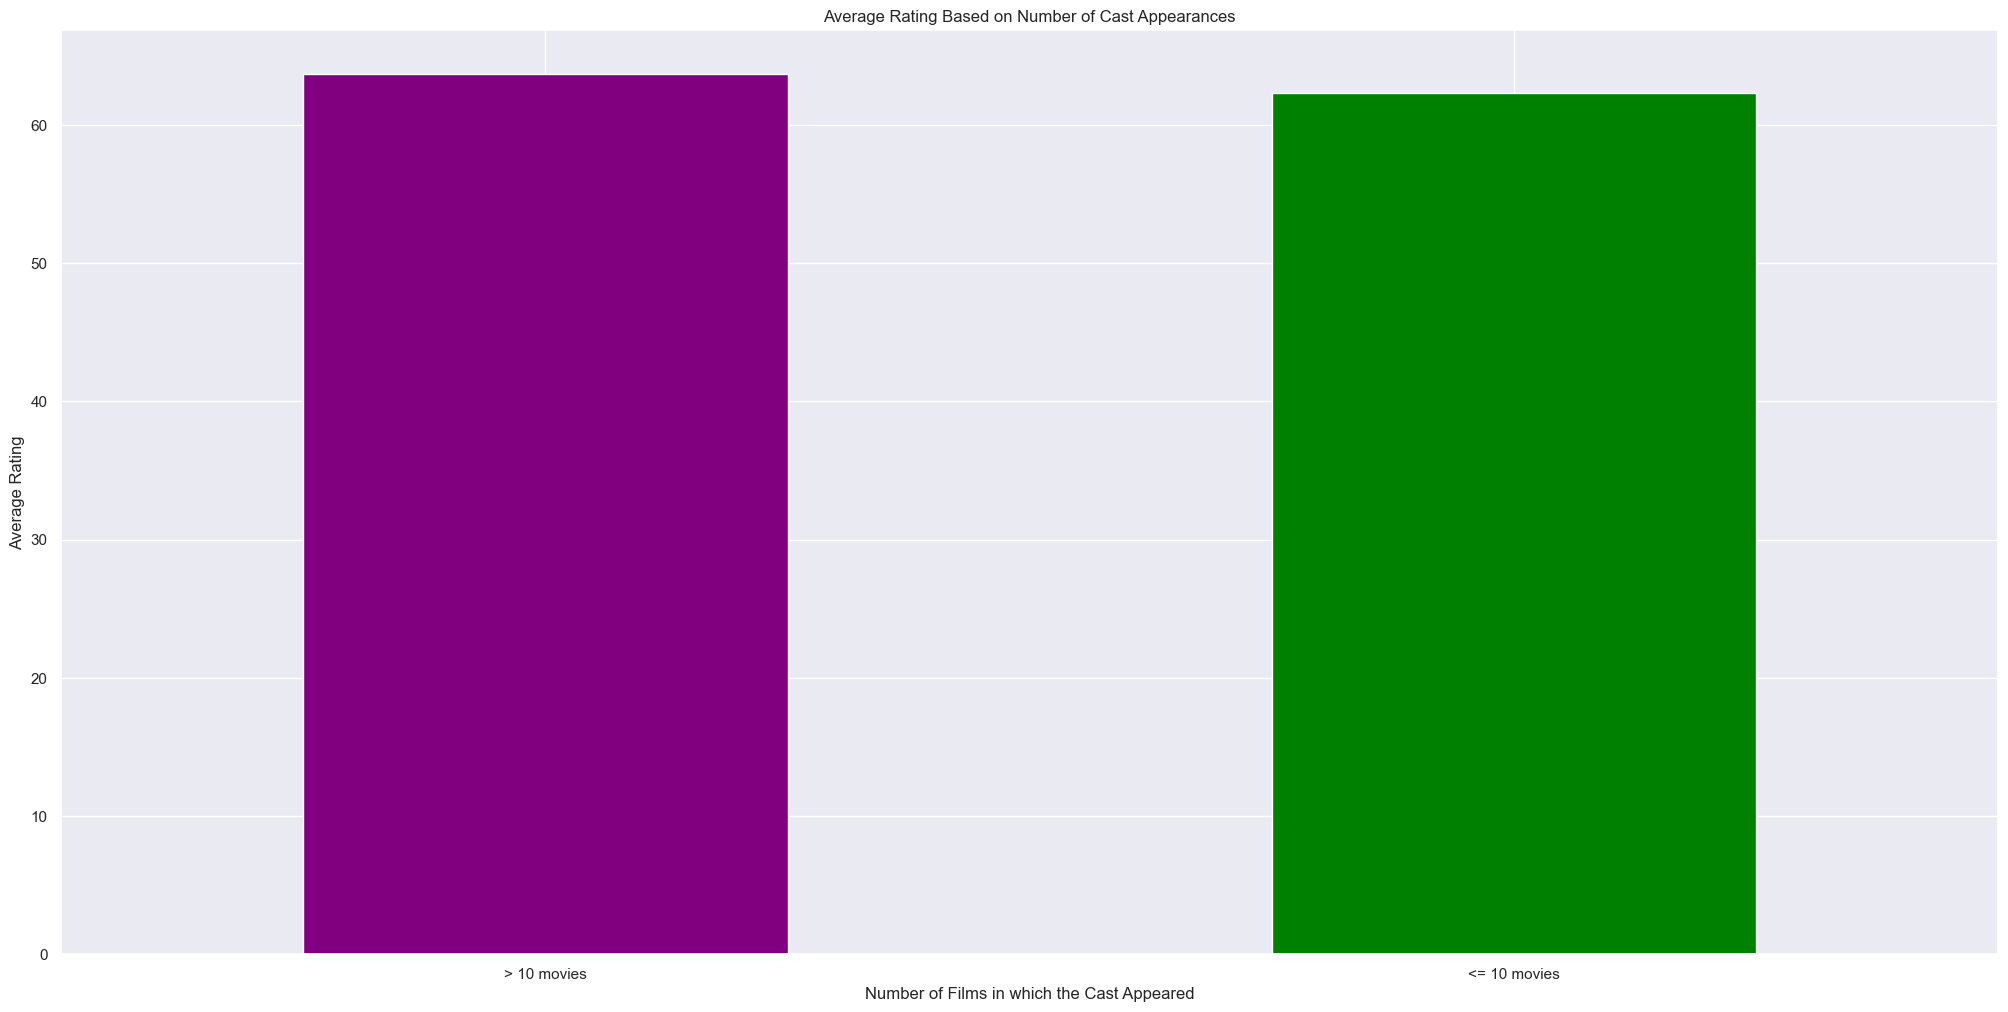

In [13]:
# Splitting the cast column and then stacking the results to get a series where each value is an actor
actors = exploratory_data_analysis['cast'].str.split(', ').dropna().explode()

# Filtering actors who appeared in more than 10 movies and 10 or fewer movies
actor_counts = actors.value_counts()
more_than_10 = actor_counts[actor_counts > 10].index
less_than_10 = actor_counts[actor_counts <= 10].index

# Calculating average ratings for both groups
rating_more_than_10 = exploratory_data_analysis[exploratory_data_analysis['cast'].str.contains('|'.join(more_than_10), na=False)]['rating'].mean()
rating_less_than_10 = exploratory_data_analysis[exploratory_data_analysis['cast'].str.contains('|'.join(less_than_10), na=False)]['rating'].mean()

actor_ratings = pd.Series([rating_more_than_10, rating_less_than_10], index=['> 10 movies', '<= 10 movies'])

actor_ratings.plot(kind='bar', color=['purple', 'green'])
plt.title('Average Rating Based on Number of Cast Appearances')
plt.ylabel('Average Rating')
plt.xlabel('Number of Films in which the Cast Appeared')
plt.xticks(rotation=0)
plt.show()

In [14]:
difference = ((actor_ratings['> 10 movies'] - actor_ratings['<= 10 movies']) / actor_ratings['<= 10 movies']) * 100

print(f"The average rating for actor with {actor_ratings.index[0]} is approximately {actor_ratings['> 10 movies']:.2f} %.")
print(f"The average rating for actor with {actor_ratings.index[1]} is approximately {actor_ratings['<= 10 movies']:.2f} %.")

print(f"The difference between the categories is {difference:.2f} % which means that", end=" ")

hipo_perc = 10
if difference >= hipo_perc:
    print(f"hypothesis was VALIDATED: actor with {actor_ratings.index[0]} have an average rating at least {hipo_perc}% higher than {actor_ratings.index[1]}.")
else:
    print(f"hypothesis was REJECTED: actor with {actor_ratings.index[0]} do not have an average rating {hipo_perc}% higher than {actor_ratings.index[1]}.")

The average rating for actor with > 10 movies is approximately 63.68 %.
The average rating for actor with <= 10 movies is approximately 62.35 %.
The difference between the categories is 2.14 % which means that hypothesis was REJECTED: actor with > 10 movies do not have an average rating 10% higher than <= 10 movies.


- Similar to hypothesis 1, we have considerably similar situations which do not allow us to extract significant information.

### **Hypothesis 4**: Films lasting more than 120 minutes have an average rating 5% lower than shorter films.

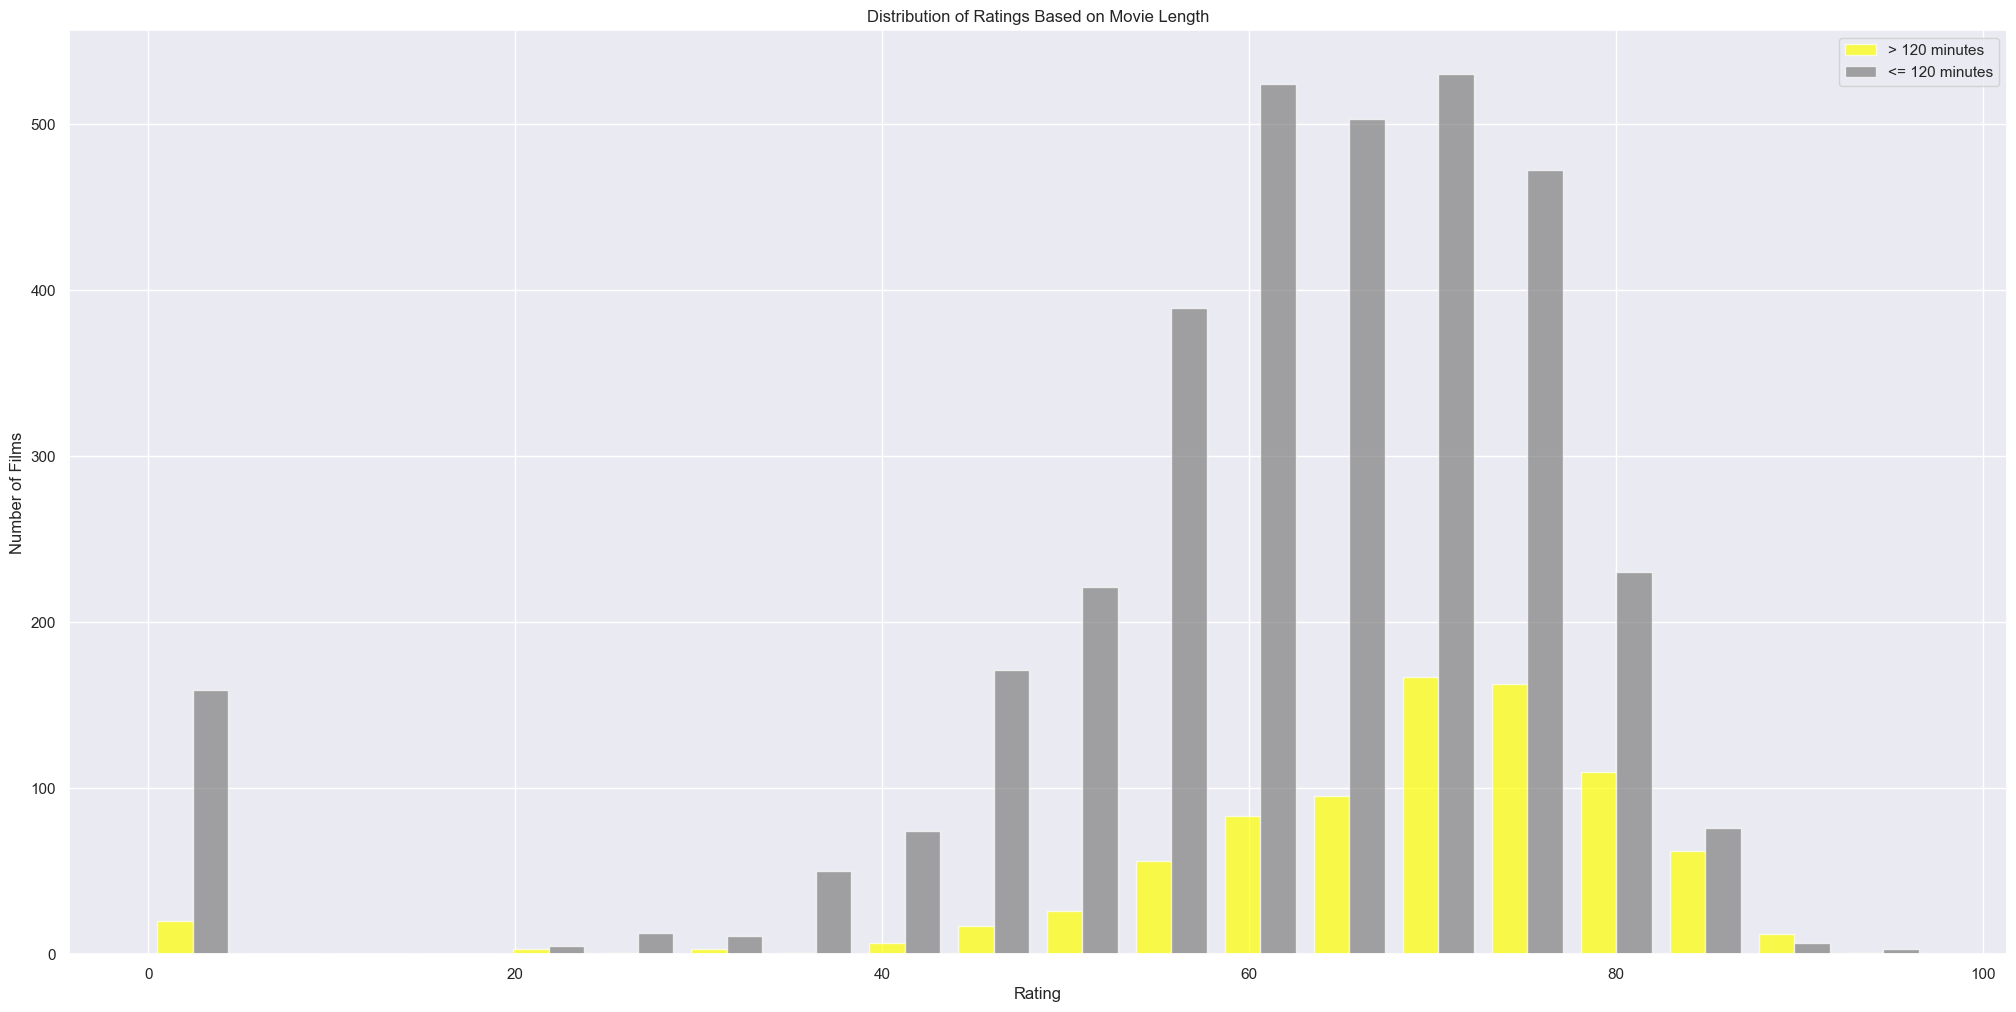

In [15]:
# Filtering movies based on duration
more_than_120 = exploratory_data_analysis[exploratory_data_analysis['minutes'] > 120]['rating']
less_than_120 = exploratory_data_analysis[exploratory_data_analysis['minutes'] <= 120]['rating']

plt.hist([more_than_120, less_than_120], bins=20, color=['yellow', 'grey'], label=['> 120 minutes', '<= 120 minutes'], alpha=0.7)
plt.title('Distribution of Ratings Based on Movie Length')
plt.ylabel('Number of Films')
plt.xlabel('Rating')
plt.legend()
plt.show()

In [16]:
mean_rating_long_movies = more_than_120.mean()
mean_rating_short_movies = less_than_120.mean()

mean_rating_movies = pd.Series([mean_rating_long_movies, mean_rating_short_movies], index=['> 120 minutes', '<= 120 minutes'])

difference = ((mean_rating_movies['<= 120 minutes'] - mean_rating_movies['> 120 minutes']) / mean_rating_movies['> 120 minutes']) * 100

print(f"The average rating for films with {mean_rating_movies.index[0]} is approximately {mean_rating_movies['> 120 minutes']:.2f} %.")
print(f"The average rating for films with {mean_rating_movies.index[1]} is approximately {mean_rating_movies['<= 120 minutes']:.2f} %.")

print(f"The difference between the categories is {difference:.2f} % which means that", end=" ")

hipo_perc = 5
if difference >= hipo_perc:
    print(f"hypothesis was VALIDATED: films with {mean_rating_movies.index[0]} have an average rating at least {hipo_perc}% lower than {mean_rating_movies.index[1]}.")
else:
    print(f"hypothesis was REJECTED: films with {mean_rating_movies.index[0]} do not have an average rating {hipo_perc}% lower than {mean_rating_movies.index[1]}.")

The average rating for films with > 120 minutes is approximately 67.95 %.
The average rating for films with <= 120 minutes is approximately 61.01 %.
The difference between the categories is -10.22 % which means that hypothesis was REJECTED: films with > 120 minutes do not have an average rating 5% lower than <= 120 minutes.


- This is a good hypothesis because it analyzes that long films should have a lower rating, which is the opposite, this can be valuable, since documentaries are the most popular type of category, there may be some association that would allow us to make future analyzes in new cycles

### **Hypothesis 5**: Films released after the year 2000 have an average rating 10% higher than films released before 2000.

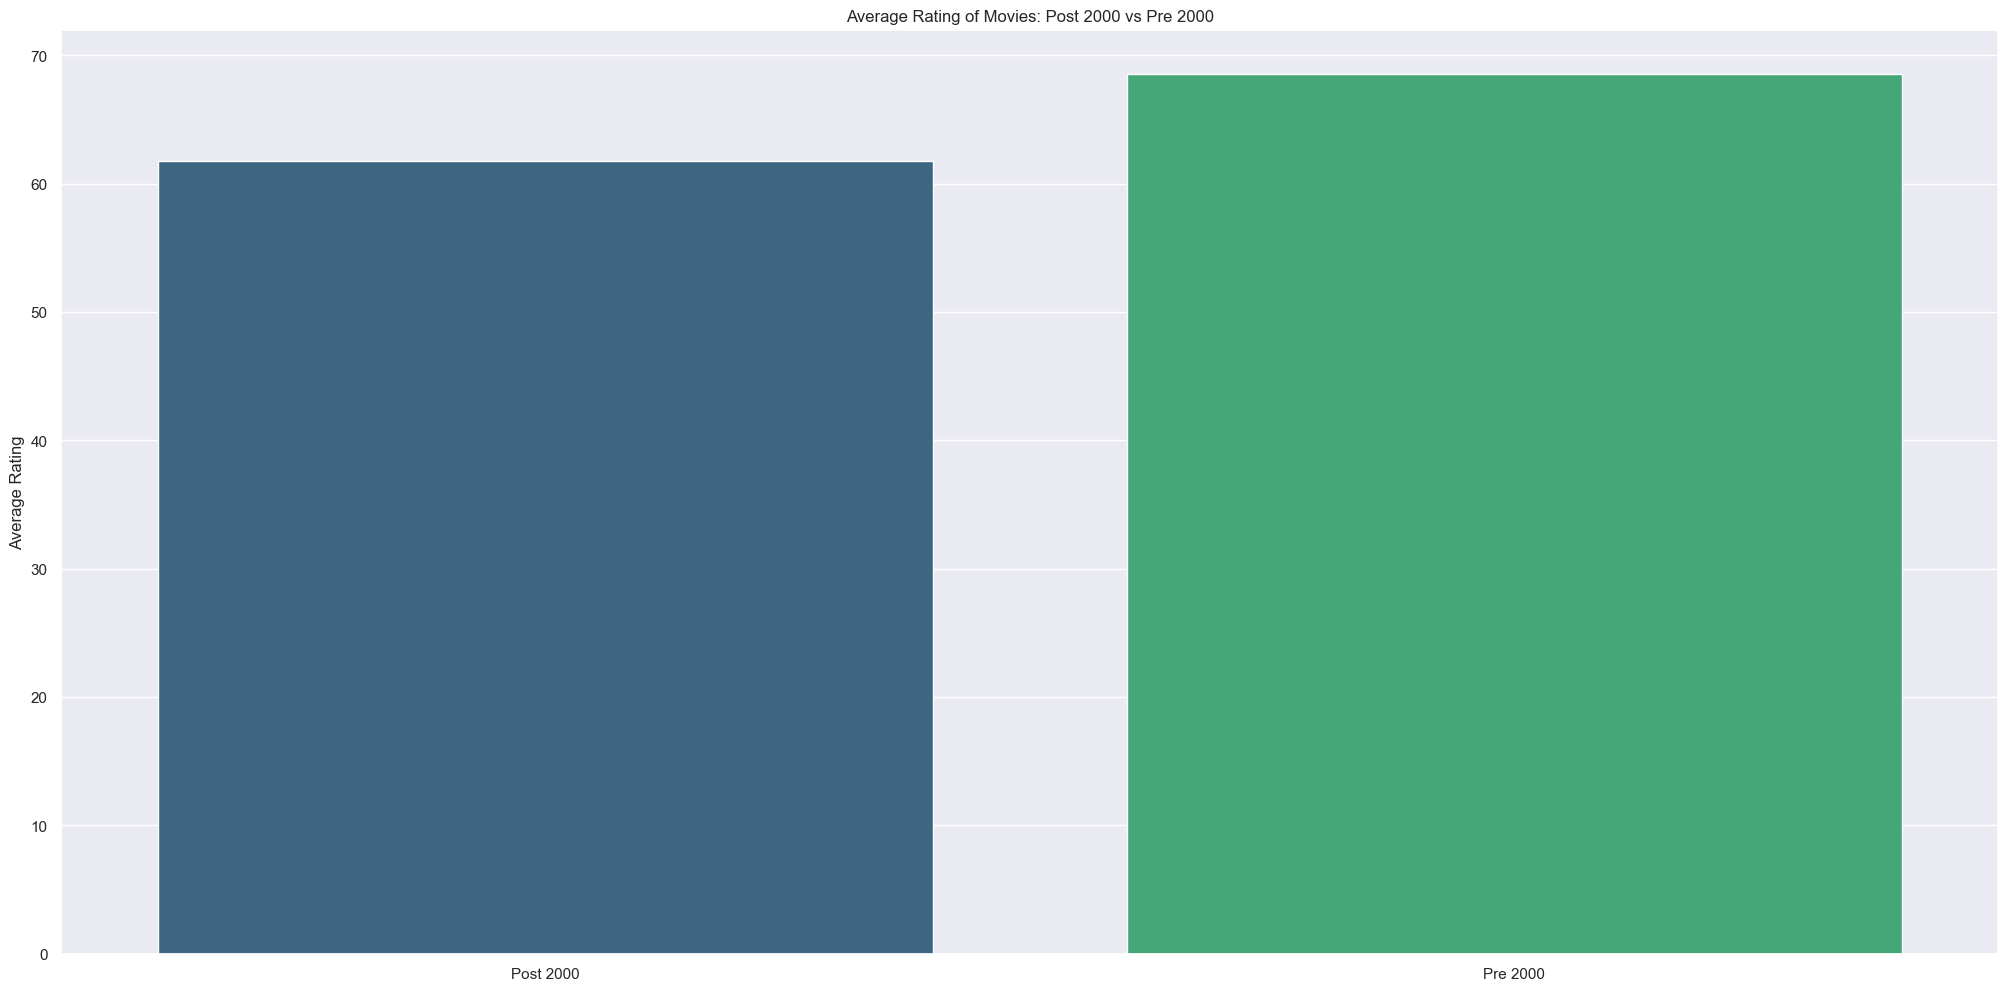

In [17]:
post_2000_movies = exploratory_data_analysis[exploratory_data_analysis['release_year'] > 2000]
pre_2000_movies = exploratory_data_analysis[exploratory_data_analysis['release_year'] <= 2000]

mean_rating_post_2000 = post_2000_movies['rating'].mean()
mean_rating_pre_2000 = pre_2000_movies['rating'].mean()

anual_labels = ['Post 2000', 'Pre 2000']
values = [mean_rating_post_2000, mean_rating_pre_2000]

sns.barplot(x=anual_labels, y=values, palette="viridis")
plt.title("Average Rating of Movies: Post 2000 vs Pre 2000")
plt.ylabel("Average Rating")
plt.show()

In [18]:
mean_rating_movies = pd.Series([mean_rating_post_2000, mean_rating_pre_2000], index=anual_labels)

difference = ((mean_rating_movies['Post 2000'] - mean_rating_movies['Pre 2000']) / mean_rating_movies['Pre 2000']) * 100

print(f"The average rating for films with {mean_rating_movies.index[0]} is approximately {mean_rating_movies['Post 2000']:.2f} %.")
print(f"The average rating for films with {mean_rating_movies.index[1]} is approximately {mean_rating_movies['Pre 2000']:.2f} %.")

print(f"The difference between the categories is {difference:.2f} % which means that", end=" ")

hipo_perc = 10
if difference >= hipo_perc:
    print(f"hypothesis was VALIDATED: films with {mean_rating_movies.index[0]} have an average rating at least {hipo_perc}% higher than {mean_rating_movies.index[1]}.")
else:
    print(f"hypothesis was REJECTED: films with {mean_rating_movies.index[0]} do not have an average rating {hipo_perc}% higher than {mean_rating_movies.index[1]}.")

The average rating for films with Post 2000 is approximately 61.77 %.
The average rating for films with Pre 2000 is approximately 68.57 %.
The difference between the categories is -9.91 % which means that hypothesis was REJECTED: films with Post 2000 do not have an average rating 10% higher than Pre 2000.


- This hypothesis has a similar pattern to the previous one: we can identify a trend of loss in valuation over time, which may motivate more detailed analysis and understand whether this temporal behavior exists.

### **Hypothesis 6**: Films released after 2010 and classified as "Sci-Fi" have an average rating 10% higher.

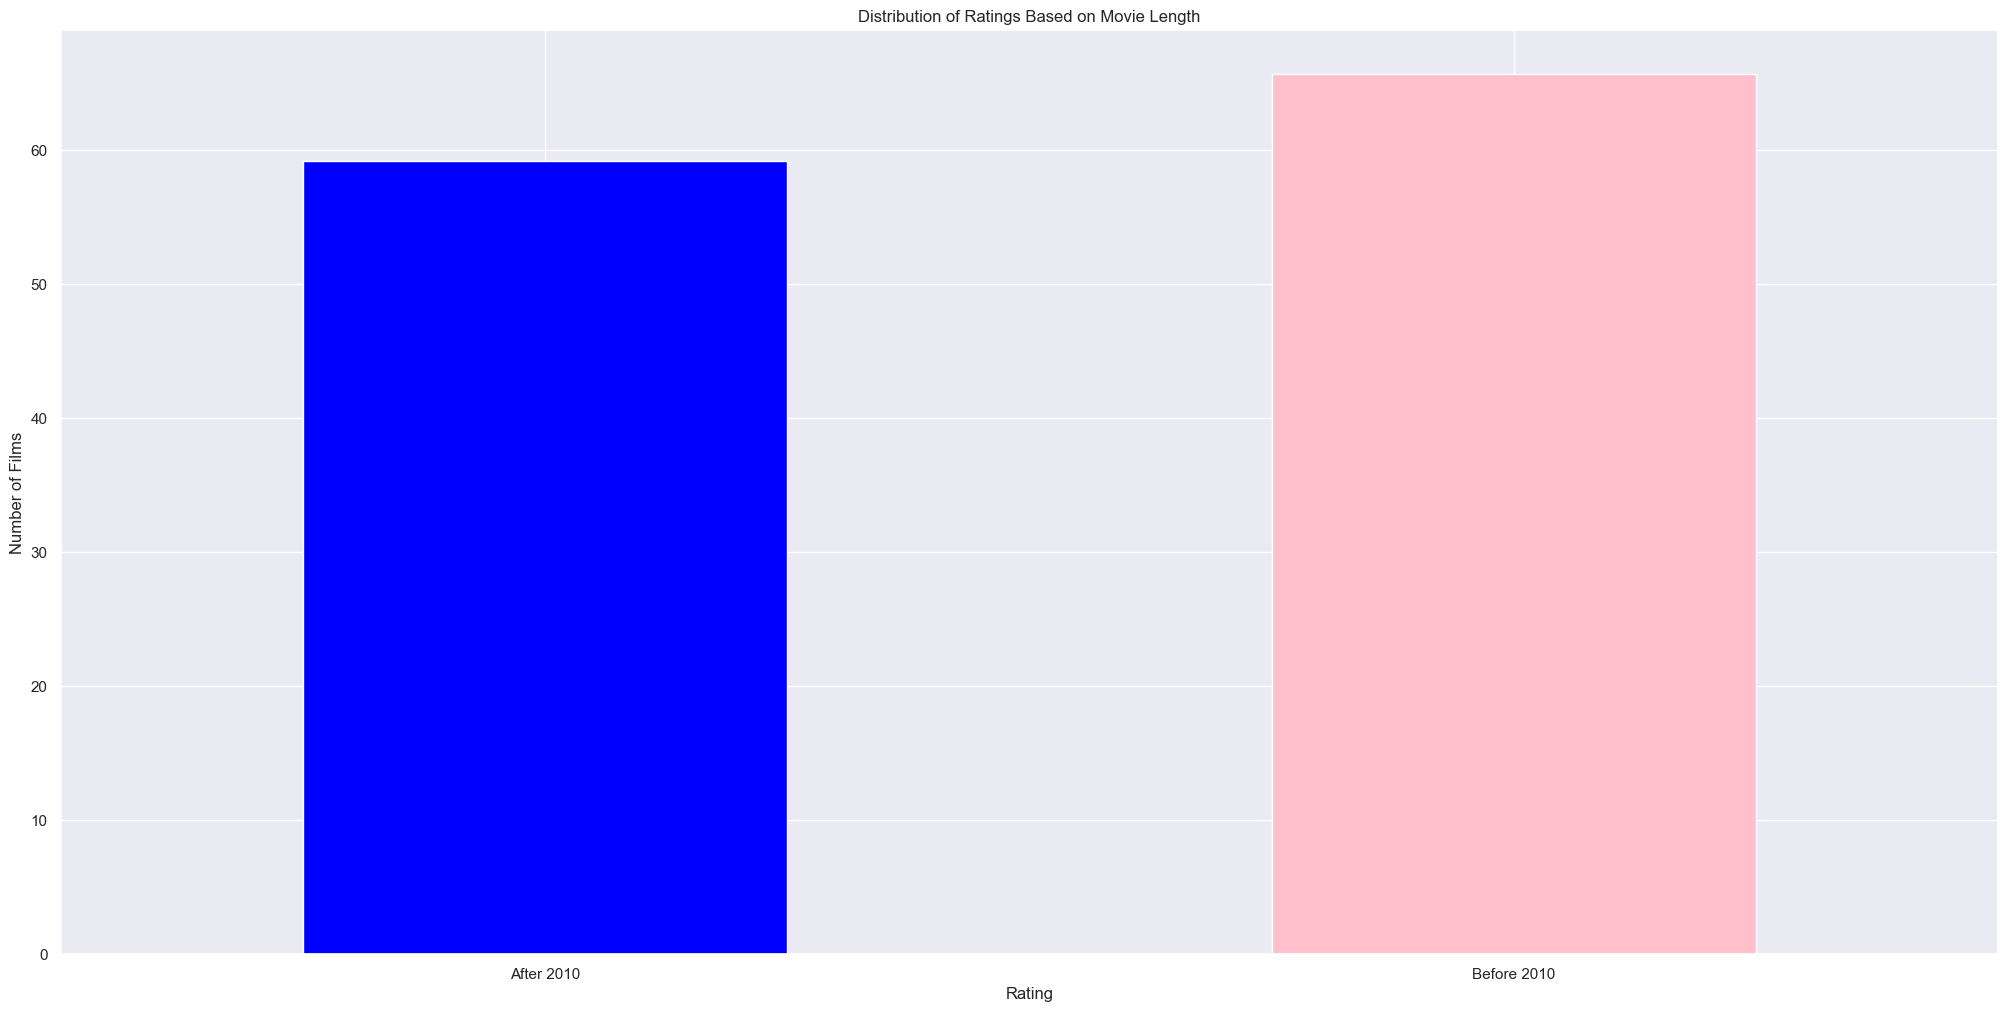

In [19]:
# Filtering Sci-Fi movies released after 2010 and before 2010
sci_fi_after_2010 = exploratory_data_analysis[(exploratory_data_analysis['release_year'] > 2010) & (exploratory_data_analysis['listed_in'].str.contains('Sci-Fi'))]['rating']
sci_fi_before_2010 = exploratory_data_analysis[(exploratory_data_analysis['release_year'] <= 2010) & (exploratory_data_analysis['listed_in'].str.contains('Sci-Fi'))]['rating']

# Calculating average ratings for both groups
avg_rating_after_2010 = sci_fi_after_2010.mean()
avg_rating_before_2010 = sci_fi_before_2010.mean()

sci_fi_ratings = pd.Series([avg_rating_after_2010, avg_rating_before_2010], index=['After 2010', 'Before 2010'])

sci_fi_ratings.plot(kind='bar', color=['blue', 'pink'])
plt.title('Distribution of Ratings Based on Movie Length')
plt.ylabel('Number of Films')
plt.xlabel('Rating')
plt.xticks(rotation=0)
plt.show()

In [20]:
difference = ((sci_fi_ratings['After 2010'] - sci_fi_ratings['Before 2010']) / sci_fi_ratings['Before 2010']) * 100

print(f"The average rating for films scifi {sci_fi_ratings.index[0]} is approximately {sci_fi_ratings['After 2010']:.2f} %.")
print(f"The average rating for films scifi {sci_fi_ratings.index[1]} is approximately {sci_fi_ratings['Before 2010']:.2f} %.")

print(f"The difference between the categories is {difference:.2f} % which means that", end=" ")

hipo_perc = 10
if difference >= hipo_perc:
    print(f"hypothesis was VALIDATED: films scifi {sci_fi_ratings.index[0]} have an average rating at least {hipo_perc}% higher than {sci_fi_ratings.index[1]}.")
else:
    print(f"hypothesis was REJECTED: films scifi {sci_fi_ratings.index[0]} do not have an average rating {hipo_perc}% higher than {sci_fi_ratings.index[1]}.")

The average rating for films scifi After 2010 is approximately 59.21 %.
The average rating for films scifi Before 2010 is approximately 65.69 %.
The difference between the categories is -9.88 % which means that hypothesis was REJECTED: films scifi After 2010 do not have an average rating 10% higher than Before 2010.


- Similar to the previous hypothesis, here we sought to understand whether the temporal behavior was associated with gender, which could mean that it was a temporal reflex and not associated with gender.

### 4.2.1 Summary of Hypotheses

- This summary table helps to understand the results of the analysis, the relevance and demonstrates the potential for insights based on the analysis and comments made.

In [21]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'High'],
       ['H3', 'False', 'Low'],
       ['H4', 'True', 'High'],
       ['H5', 'False', 'Average'],
       ['H6', 'False', 'Average'],
      ]
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         High
H3            False         Low
H4            True          High
H5            False         Average
H6            False         Average


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

In [22]:
num_attributes = exploratory_data_analysis.select_dtypes(include='number')
correlation = num_attributes.corr(method='pearson')

fig = ff.create_annotated_heatmap(
    z=correlation.values, 
    x=list(correlation.columns), 
    y=list(correlation.index), 
    annotation_text=correlation.round(2).values, 
    showscale=True,
    colorscale='Bluered'
)
fig.show()

### 4.3.2 Categorical Attributes

In [23]:
# only categorical data
cat_attributes = exploratory_data_analysis.select_dtypes(include='object')

# Cramer V correlation
correlation = pycorrcat.corr_matrix(cat_attributes, list(cat_attributes.columns))

fig = ff.create_annotated_heatmap(
    z=correlation.values, 
    x=list(correlation.columns), 
    y=list(correlation.index), 
    annotation_text=correlation.round(2).values, 
    showscale=True,
    colorscale='Bluered'
)
fig.show()

In [24]:
catalog.save("exploratory_data_analysis", exploratory_data_analysis)

[09/23/23 17:29:23] INFO     Saving data to 'exploratory_data_analysis' (CSVDataSet)...         ]8;id=221960;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=166939;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\